In [13]:
# Covid-19 Case Analysis
# Michael Van Dyken


In [70]:
pip install geopandas


Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels
Note: you may need to restart the kernel to use updated packages.


In [72]:
# Imported relevant libraries 
import geopandas as gpd 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import contextily 
import mapclassify 
import folium
import aiohttp
import fsspec

# GeoDataFrame containing United States geometry shapes (at a state-level) loaded:
data = "https://github.com/babdelfa/gis/blob/main/state_geometry.zip?raw=true"
with fsspec.open(data) as file:
    state_shapes = gpd.read_file(file)

# DataFrame containing United States COVID-19 cumulative case data over time loaded:
df = pd.read_csv("https://raw.githubusercontent.com/babdelfa/project/main/cases.csv")

In [74]:
# state_shapes Data Sample
state_shapes.head()

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
0,Hawaii,1,15,Pacific,HI,"MULTIPOLYGON (((-160.0738 22.00418, -160.04971..."
1,Washington,2,53,Pacific,WA,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628..."
2,Montana,3,30,Mountain,MT,"POLYGON ((-111.47543 44.70216, -111.4808 44.69..."
3,Maine,4,23,New England,ME,"MULTIPOLYGON (((-69.77728 44.07415, -69.85993 ..."
4,North Dakota,5,38,West North Central,ND,"POLYGON ((-98.73044 45.93827, -99.00683 45.939..."


In [16]:
# Data sample
df

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,State_Abbr,Country_Region,Lat,...,12/22/2022,12/23/2022,12/24/2022,12/25/2022,12/26/2022,12/27/2022,12/28/2022,12/29/2022,12/30/2022,12/31/2022
0,84001001,US,USA,840,1001.0,Autauga,Alabama,AL,US,32.539527,...,18961,18961,18961,18961,18961,18961,18961,18961,18961,18961
1,84001003,US,USA,840,1003.0,Baldwin,Alabama,AL,US,30.727750,...,67496,67496,67496,67496,67496,67496,67496,67496,67496,67496
2,84001005,US,USA,840,1005.0,Barbour,Alabama,AL,US,31.868263,...,7027,7027,7027,7027,7027,7027,7027,7027,7027,7027
3,84001007,US,USA,840,1007.0,Bibb,Alabama,AL,US,32.996421,...,7692,7692,7692,7692,7692,7692,7692,7692,7692,7692
4,84001009,US,USA,840,1009.0,Blount,Alabama,AL,US,33.982109,...,17731,17731,17731,17731,17731,17731,17731,17731,17731,17731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3251,84056039,US,USA,840,56039.0,Teton,Wyoming,WY,US,43.935225,...,11997,11997,11997,11997,11997,12010,12010,12010,12010,12010
3252,84056041,US,USA,840,56041.0,Uinta,Wyoming,WY,US,41.287818,...,6303,6303,6303,6303,6303,6305,6305,6305,6305,6305
3253,84090056,US,USA,840,90056.0,Unassigned,Wyoming,WY,US,0.000000,...,0,0,0,0,0,0,0,0,0,0
3254,84056043,US,USA,840,56043.0,Washakie,Wyoming,WY,US,43.904516,...,2717,2717,2717,2717,2717,2722,2722,2722,2722,2722


In [17]:
# View data types
state_shapes.dtypes

STATE_NAME      object
DRAWSEQ          int32
STATE_FIPS      object
SUB_REGION      object
STATE_ABBR      object
geometry      geometry
dtype: object

In [18]:
# View data types
df.dtypes

UID             int64
iso2           object
iso3           object
code3           int64
FIPS          float64
               ...   
12/27/2022      int64
12/28/2022      int64
12/29/2022      int64
12/30/2022      int64
12/31/2022      int64
Length: 1087, dtype: object

In [19]:
# Columns Renamed for Clarity
df.rename(columns = {'Province_State': 'State_Name', 'Admin2': 'County_Name'}, inplace = True)
state_shapes.rename(columns = {'STATE_NAME': 'State_Name', 'STATE_ABBR': 'State_Abbr'}, inplace = True)

In [20]:
# Date Columns and County Identifiers 
date_columns = [col for col in df.columns if col.startswith(('1/', '2/', '3/', '4/', '5/', '6/', '7/', '8/', '9/', '10/', '11/', '12/'))]
county_identifiers = ['FIPS', 'County_Name', 'State_Name']

In [21]:
# County Identifiers Converted to Long Format
df_long = df.melt(
    id_vars=county_identifiers, 
    value_vars=date_columns,    
    var_name='Date',            
    value_name='Cases')
df_long

,FIPS,County_Name,State_Name,Date,Cases
0,1001.0,Autauga,Alabama,1/22/2020,0
1,1003.0,Baldwin,Alabama,1/22/2020,0
2,1005.0,Barbour,Alabama,1/22/2020,0
3,1007.0,Bibb,Alabama,1/22/2020,0
4,1009.0,Blount,Alabama,1/22/2020,0
...,...,...,...,...,...
3500195,56039.0,Teton,Wyoming,12/31/2022,12010
3500196,56041.0,Uinta,Wyoming,12/31/2022,6305
3500197,90056.0,Unassigned,Wyoming,12/31/2022,0
3500198,56043.0,Washakie,Wyoming,12/31/2022,2722


In [22]:
# Converted to DateTime Format
df_long['Date'] = pd.to_datetime(df_long['Date'])

In [23]:
# Aggregate State Case Data
df_state_agg = df_long.groupby(['State_Name', 'Date'])['Cases'].sum().reset_index()
print(df_state_agg)

      State_Name       Date   Cases
0        Alabama 2020-01-22       0
1        Alabama 2020-01-23       0
2        Alabama 2020-01-24       0
3        Alabama 2020-01-25       0
4        Alabama 2020-01-26       0
...          ...        ...     ...
54820    Wyoming 2022-12-27  182847
54821    Wyoming 2022-12-28  182847
54822    Wyoming 2022-12-29  182847
54823    Wyoming 2022-12-30  182847
54824    Wyoming 2022-12-31  182847

[54825 rows x 3 columns]


In [24]:
# Aggregate County Case Data
df_county_agg = df_long.groupby(['County_Name', 'Date']).agg(Cumulative_Cases=('Cases', 'sum')).reset_index()
print(df_county_agg)

        County_Name       Date  Cumulative_Cases
0         Abbeville 2020-01-22                 0
1         Abbeville 2020-01-23                 0
2         Abbeville 2020-01-24                 0
3         Abbeville 2020-01-25                 0
4         Abbeville 2020-01-26                 0
...             ...        ...               ...
2045720     Ziebach 2022-12-27               707
2045721     Ziebach 2022-12-28               707
2045722     Ziebach 2022-12-29               707
2045723     Ziebach 2022-12-30               707
2045724     Ziebach 2022-12-31               707

[2045725 rows x 3 columns]


In [25]:
# Date Data Grouped by State Condensed to Quarters for Readability 
df_quarterly = df_state_agg.groupby(['State_Name']).resample('Q', on='Date')['Cases'].last().reset_index()
df_quarterly['Date'] = df_quarterly['Date']  
print(df_quarterly)

    State_Name       Date   Cases
0      Alabama 2020-03-31    1063
1      Alabama 2020-06-30   38477
2      Alabama 2020-09-30  154772
3      Alabama 2020-12-31  361226
4      Alabama 2021-03-31  515388
..         ...        ...     ...
607    Wyoming 2021-12-31  115638
608    Wyoming 2022-03-31  156112
609    Wyoming 2022-06-30  164456
610    Wyoming 2022-09-30  176728
611    Wyoming 2022-12-31  182847

[612 rows x 3 columns]


In [26]:
# Date Data Condensed to Quarters for Readability 
df_quarterly_us = df_quarterly.groupby('Date')['Cases'].sum().div(1000000).reset_index()
print(df_quarterly_us)

         Date      Cases
0  2020-03-31   0.191587
1  2020-06-30   2.646584
2  2020-09-30   7.218173
3  2020-12-31  20.133972
4  2021-03-31  30.460993
5  2021-06-30  33.629699
6  2021-09-30  43.336133
7  2021-12-31  54.602341
8  2022-03-31  79.663048
9  2022-06-30  86.810627
10 2022-09-30  95.301041
11 2022-12-31  99.605471


In [27]:
# Cumulative Cases for Each County
county_cumulative = df_long[df_long.Date == '12/31/2022'].groupby(['County_Name'])['Cases'].sum().reset_index()
print(county_cumulative)

        County_Name   Cases
0         Abbeville    7597
1            Acadia   18512
2          Accomack    8698
3               Ada  157422
4             Adair   25392
...             ...     ...
1898  Yukon-Koyukuk    1705
1899           Yuma   72199
1900         Zapata    4362
1901         Zavala    4473
1902        Ziebach     707

[1903 rows x 2 columns]


In [28]:
# Cumulative Cases for Each State
states = df_long[df_long.Date == '12/31/2022'].groupby(["State_Name"])['Cases'].sum().reset_index()
print(states)

              State_Name     Cases
0                Alabama   1568934
1                 Alaska    301432
2                Arizona   2378334
3               Arkansas    985493
4             California  11835094
5               Colorado   1734782
6            Connecticut    948943
7               Delaware    321888
8   District of Columbia    173386
9                Florida   7338503
10               Georgia   2985193
11                Hawaii    372198
12                 Idaho    511601
13              Illinois   3969832
14               Indiana   2002760
15                  Iowa    886411
16                Kansas    917065
17              Kentucky   1662581
18             Louisiana   1514113
19                 Maine    306647
20              Maryland   1318234
21         Massachusetts   2154886
22              Michigan   2988654
23             Minnesota   1736893
24           Mississippi    955145
25              Missouri   1732724
26               Montana    323055
27              Nebr

In [29]:
# Cumulative COVID-19 cases for the entire US as of December 31, 2022.
print(states.sum())

State_Name    AlabamaAlaskaArizonaArkansasCaliforniaColorado...
Cases                                                  99605471
dtype: object


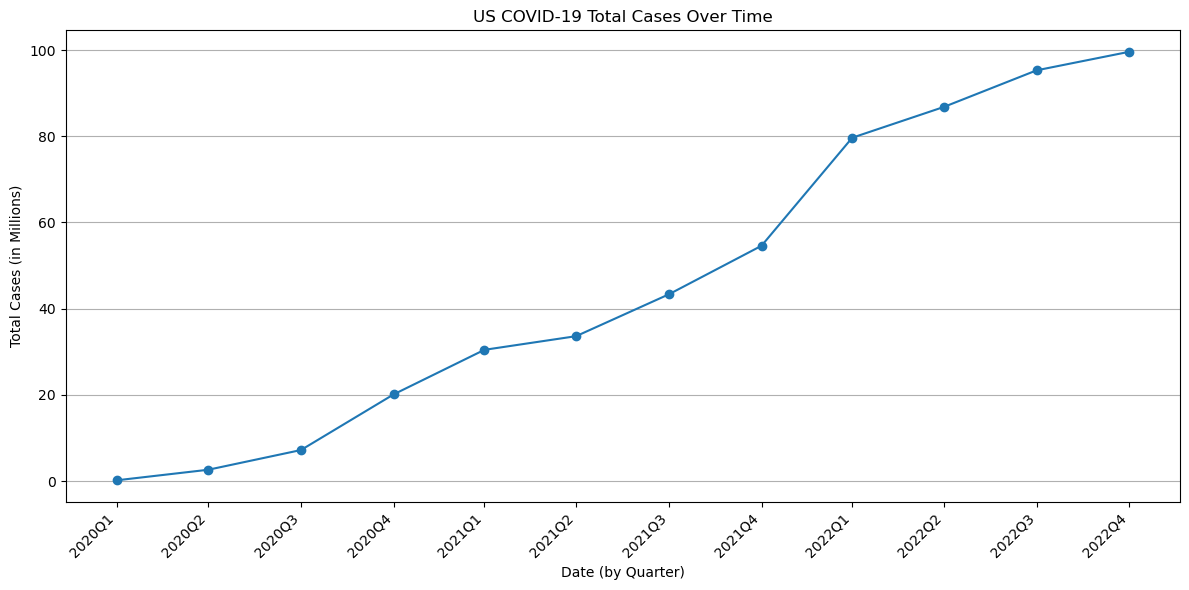

In [30]:
# Time series plot of cumulative cases for the entire US. 
plt.figure(figsize=(12, 6))
plt.plot(df_quarterly_us['Date'], df_quarterly_us['Cases'], marker = 'o')
ax = plt.gca()
df_quarterly_us['Quarter_Year'] = df_quarterly_us['Date'].dt.to_period('Q').astype(str)
ax.set_xticks(df_quarterly_us['Date'].unique())  
ax.set_xticklabels(df_quarterly_us['Quarter_Year'].unique())
plt.xticks(rotation=45, ha='right')
plt.xlabel('Date (by Quarter)')
plt.ylabel('Total Cases (in Millions)')
plt.title('US COVID-19 Total Cases Over Time')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [31]:
# Top 5 states with the highest cumulative cases identified.
top_5_values = states.nlargest(5, 'Cases')[['State_Name', 'Cases']]
print(top_5_values)

    State_Name     Cases
4   California  11835094
43       Texas   8211376
9      Florida   7338503
32    New York   6574004
13    Illinois   3969832


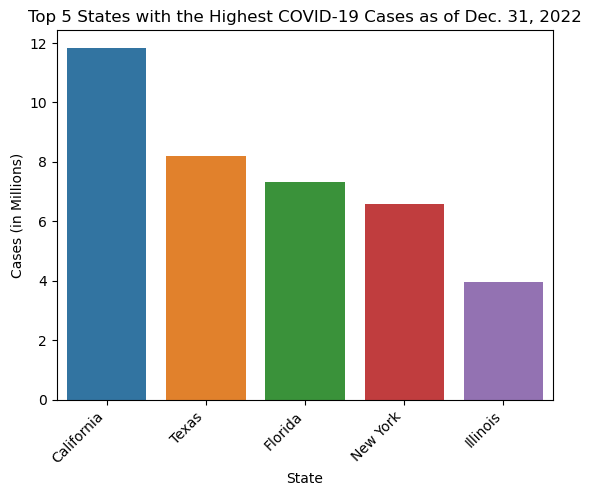

In [32]:
# Top 5 states with the highest cumulative cases plotted. 
top_states = states.groupby(["State_Name"])['Cases'].sum().div(1000000).reset_index()
top_state_values = top_states.nlargest(5, 'Cases')[['State_Name', 'Cases']]
sns.barplot(x='State_Name', y='Cases', data = top_state_values, )
plt.title('Top 5 States with the Highest COVID-19 Cases as of Dec. 31, 2022')
plt.xticks(rotation=45, ha='right')
plt.xlabel('State')
plt.ylabel('Cases (in Millions)')
plt.show()

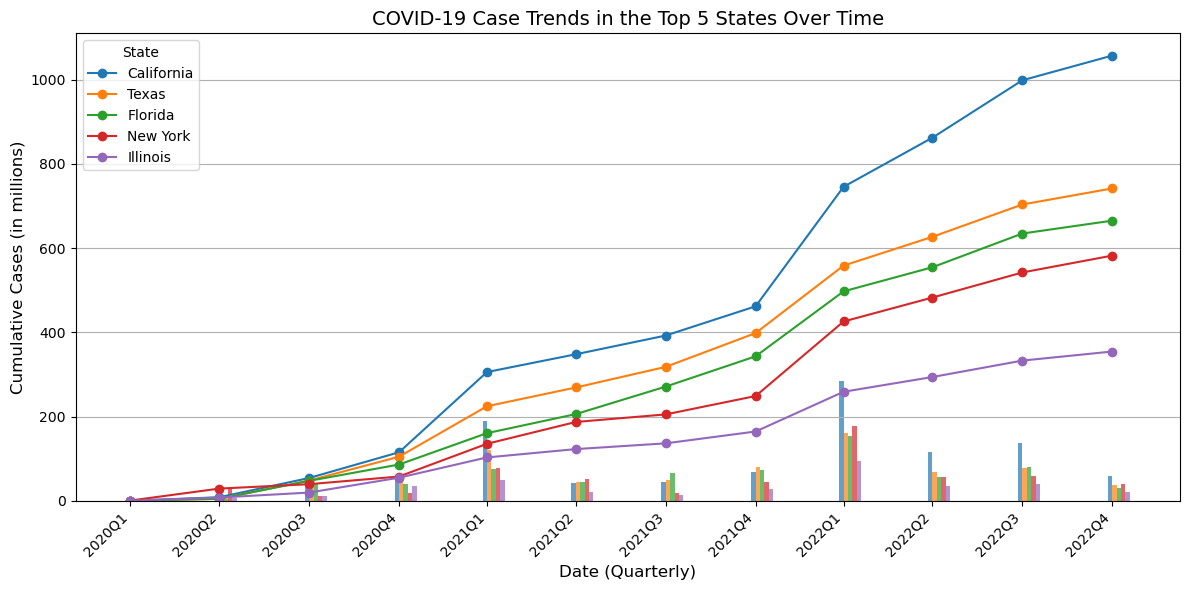

In [33]:
# Time series plot contrasting trends of cumulative cases for the top 5 states.
# Cumulative cases and growth rates plotted on the same graph.
top_5_agg = df_state_agg[df_state_agg['State_Name'].isin(['California', 'Texas', 'Florida', 'New York', 'Illinois'])]
top_5_agg.set_index(['Date'], inplace=True)
state_order = ['California', 'Texas', 'Florida', 'New York', 'Illinois']

# Aggregate to quarterly and divide by 1,000,000
top5_quarterly_agg = (top_5_agg
                      .groupby('State_Name')
                      .resample('Q')['Cases']
                      .sum()
                      .div(1000000) 
                      .reset_index())

# New Cases per Quarter
top5_quarterly_agg['New_Cases'] = top5_quarterly_agg.groupby('State_Name')['Cases'].diff()
top5_quarterly_agg['New_Cases'].fillna(top5_quarterly_agg['Cases'], inplace=True)  


plt.figure(figsize=(12, 6))
colors = plt.colormaps['tab10'](range(len(top5_quarterly_agg['State_Name'].unique())))

# Cumulative Cases 
ax1 = plt.gca()  
for i, state in enumerate(state_order):
    state_data = top5_quarterly_agg[top5_quarterly_agg['State_Name'] == state]
    ax1.plot(state_data['Date'], state_data['Cases'], marker='o', linestyle='-', label=state, color=colors[i])

ax1.set_xlabel('Date (Quarterly)', fontsize=12)
ax1.set_ylabel('Cumulative Cases (in millions)', fontsize=12)
ax1.set_title('COVID-19 Case Trends in the Top 5 States Over Time', fontsize=14)
ax1.legend(title='State')
ax1.grid(axis='y', linestyle='-')

# Growth Rates
for i, state in enumerate(state_order):
    state_data = top5_quarterly_agg[top5_quarterly_agg['State_Name'] == state].copy()
    bar_width = pd.Timedelta('90 days') / (len(top5_quarterly_agg['State_Name'].unique()) + 15) 
    offset = bar_width * i 
    x_values = state_data['Date'] + offset - bar_width / 2 
    ax1.bar(x_values, state_data['New_Cases'], width=bar_width, alpha=0.7, label=state, color=colors[i])

# Additional Customization
top5_quarterly_agg['Quarter_Year'] = top5_quarterly_agg['Date'].dt.to_period('Q').astype(str)
ax1.set_xticks(top5_quarterly_agg['Date'].unique())
ax1.set_xticklabels(top5_quarterly_agg['Quarter_Year'].unique()) 
ax1.tick_params(axis='y')
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

In [34]:
# Top 5 counties with the highest cumulative cases. 
top_5_counties = county_cumulative.nlargest(5, 'Cases')[['County_Name', 'Cases']]
print(top_5_counties)

      County_Name    Cases
989   Los Angeles  3631736
1092   Miami-Dade  1494039
394          Cook  1493629
1028     Maricopa  1484296
1232       Orange  1448295


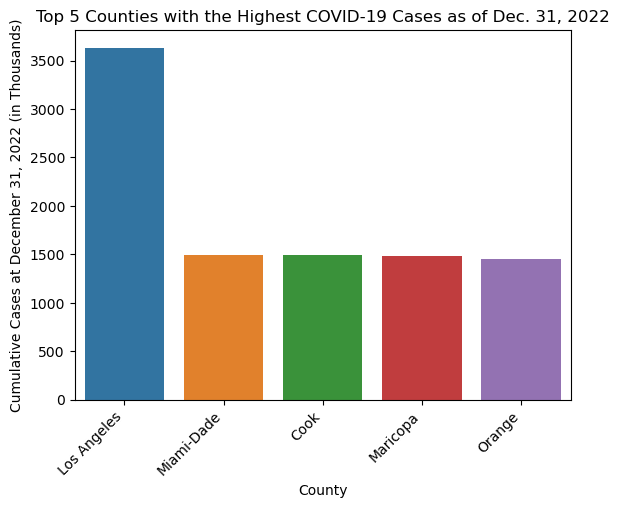

In [35]:

# Top 5 counties with the highest cumulative cases. 
# Each bar represents a county and their cumulative cases.
top_counties = top_5_counties.groupby(["County_Name"])['Cases'].sum().div(1000).reset_index()
top_counties.sort_values(by='Cases', ascending=False, inplace=True)
sns.barplot(x='County_Name', y='Cases', data = top_counties)
plt.title('Top 5 Counties with the Highest COVID-19 Cases as of Dec. 31, 2022')
plt.xticks(rotation=45, ha='right')
plt.xlabel('County')
plt.ylabel('Cumulative Cases at December 31, 2022 (in Thousands)')
plt.show()

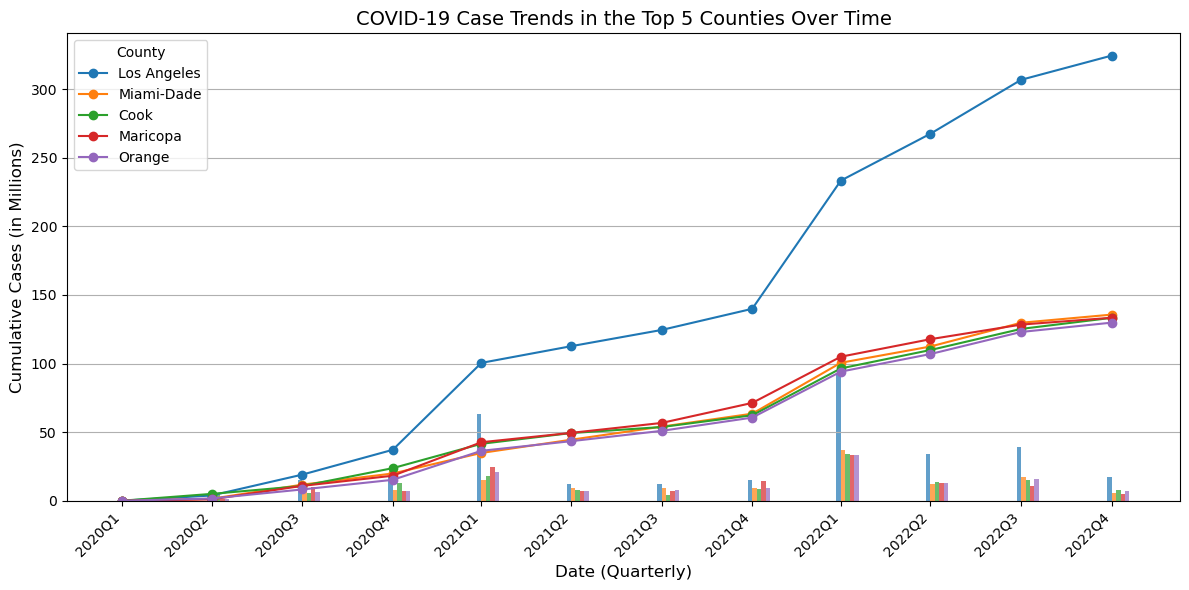

In [36]:
# Time series plot contrasting trends of cumulative cases for the top 5 counties.
# Cumulative cases and new cases plotted on the same graph.

top_5county_agg = df_county_agg[df_county_agg['County_Name'].isin(['Los Angeles', 'Miami-Dade', 'Cook', 'Maricopa', 'Orange'])]
top_5county_agg.set_index(['Date'], inplace=True)
county_order = ['Los Angeles', 'Miami-Dade', 'Cook', 'Maricopa', 'Orange']

# Aggregate to quarterly and divide by 1,000,000
top5county_quarterly_agg = (top_5county_agg
                            .groupby('County_Name')
                            .resample('Q')['Cumulative_Cases']
                            .sum()
                            .div(1000000) 
                            .reset_index())

# New Cases per Quarter
top5county_quarterly_agg['New_Cases'] = (top5county_quarterly_agg
                                        .groupby('County_Name')['Cumulative_Cases']
                                        .diff())

# First value filled with cumulative cases for the quarter
top5county_quarterly_agg['New_Cases'].fillna(
    top5county_quarterly_agg['Cumulative_Cases'], inplace=True)

# Plot
plt.figure(figsize=(12, 6))
colors = plt.colormaps['tab10'](
    range(len(top5county_quarterly_agg['County_Name'].unique())))

# Plot Cumulative Cases
ax1 = plt.gca()  # Current axis
for i, county in enumerate(county_order):
    county_data = top5county_quarterly_agg[top5county_quarterly_agg['County_Name'] == county]
    ax1.plot(county_data['Date'], county_data['Cumulative_Cases'], marker='o', linestyle='-', label=county, color=colors[i])

plt.xticks(rotation=45, ha='right')
ax1.set_xlabel('Date (Quarterly)', fontsize=12)
ax1.set_ylabel('Cumulative Cases (in Millions)', fontsize=12)
ax1.set_title('COVID-19 Case Trends in the Top 5 Counties Over Time', fontsize=14)
ax1.legend(title='County')
ax1.grid(axis='y', linestyle='-')

# Formatted
top5county_quarterly_agg['Quarter_Year'] = top5county_quarterly_agg['Date'].dt.to_period('Q').astype(str)
ax1.set_xticks(top5county_quarterly_agg['Date'].unique())
ax1.set_xticklabels(top5county_quarterly_agg['Quarter_Year'].unique())
plt.xticks(rotation=45, ha='right')

# New Cases per Quarter
for i, county in enumerate(county_order):
    county_data = top5county_quarterly_agg[top5county_quarterly_agg['County_Name'] == county].copy()
    bar_width = pd.Timedelta('90 days') / (len(top5county_quarterly_agg['County_Name'].unique()) + 15)
    offset = bar_width * i
    x_values = county_data['Date'] + offset - bar_width / 2  
    ax1.bar(x_values, county_data['New_Cases'], width=bar_width, alpha=0.7, label=county, color=colors[i])


plt.tight_layout()
plt.show()

In [37]:
# Interactive choropleth map showing detailed information for the top 5 states with the highest cumulative cases.
gdf = pd.merge(state_shapes, top_5_values, left_on = 'State_Name', right_on = 'State_Name')
gdf.explore(column="Cases", cmap="Reds", legend=True, scheme='EqualInterval')